# Representation Similarity Encoding

To illustrate how does representation similarity encoding work  
Reference: __Anderson, Zinszer, & Raizada (2016), Representational similarity encoding for fMRI: Pattern-based synthesis to predict brain activity using stimulus-model-similarities, NeuroImage.__  
Tutorial author: Huanqing

Fig illustration
![Conceptual figure](https://github.com/huanqingwang/fMRI/blob/main/pics_material/rse_illustrate_1.PNG?raw=true)  
![Formula figure](https://github.com/huanqingwang/fMRI/blob/main/pics_material/rse_illustrate_2.PNG?raw=true)  


Conceptually, the steps will be:  
1. We want a new stimulus-model feature-vector, so we need to have a new specific stimuli
2. Generate a new similarity-code for new stimuli
3. Transfer code from step 2 to match a stored pattern (i.e., stored feature-vector)
4. Synthesis the new pattern by applying the code as weights in a superposition of the stored pattern

## Using Amazon food review dataset as a pilot study

Open dataset link:  
https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews?resource=download

In this case, we want to predict new costomer's scoring based on their review.  
So, __similarity code__ will be: semantic similarity between new review and stored reviews,
__feature-vector__ will be: customer scorings (in this case, is a one-dimension variable).  

Initialize

In [3]:
## import packages
import numpy as np
import scipy
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
model = SentenceTransformer('bert-base-nli-mean-tokens')

In [2]:
## import dataset
df_review_temp = pd.read_csv('D:/Download/archive/Reviews.csv')
#df_review_temp = pd.read_csv('E:/WagnerLab/nlp/Reviews.csv')

### Using 8000 reviews as training set to predict the new 51 scores

Training set is the stored feature-vector

In [3]:
## use the top 8000 people as training set
df_review = df_review_temp.iloc[:8000,:]
## calculate text vectors
df_review_embedding = model.encode(df_review.iloc[:,-1])
df_review_embedding = pd.DataFrame(df_review_embedding) # convert to data frame
## the output semantic vector has 768 vectors
## df_review_embedding = np.array(df_review_embedding) # turn back to array if neccessary

Save the text vectors if neccesary

In [4]:
## the calculation time is too long, save the text vector for future use
#df_review_embedding.to_csv('D:/Download/archive/embedding_8000.csv')

Create testing set and make prediction

C:\Users\wang.12754\AppData\Local\Temp\25\ipykernel_14476\2555202143.py:42: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  ori_score = ori_score.astype(np.float)


the performance is (0.6034050862995167, 2.775037709630994e-06)


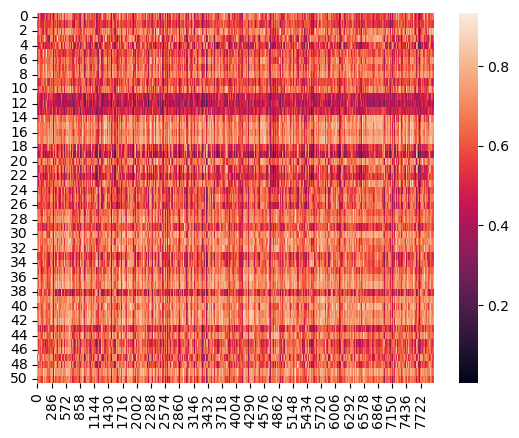

In [4]:
## predict a new stimuli's vector, in this case, new people's score
## get the written review 
df_review_test_1 = df_review_temp.iloc[8000:8051,:] ## the 8001-8051 customer
## reset index
df_review_test_1 = df_review_test_1.reset_index(drop=True)
## calculate text vectors for test data
df_review_embedding_test_1 = model.encode(df_review_test_1.iloc[:,-1])
## get the similarity code
## a loop to create review similarity code
df_sim_code = np.zeros((len(df_review_embedding_test_1),len(df_review_embedding)))
df_sim_code = pd.DataFrame(df_sim_code)
df_review_embedding = np.array(df_review_embedding) # turn back to array for similarity calculation
df_review_embedding_test_1 = np.array(df_review_embedding_test_1) # turn back to array for similarity calculation

for i in range(0,len(df_review_embedding_test_1)):
    for j in range(0,len(df_review_embedding)):
        df_sim_code.iloc[i,j] = cosine_similarity([df_review_embedding_test_1[i],df_review_embedding[j]])[0,1] ## similarity between test data and train data
## visualize the similarity code
sns.heatmap(df_sim_code)
## create a data frame to put c score, which is the sum of absolute correlation value between training set and testing set
df_c_score =  np.zeros((len(df_review_embedding_test_1),1))
## df_c_score[0] = 1
## try_1 = abs(df_sim_code.iloc[0,:])
## try_1_1 = sum(abs(df_sim_code.iloc[0,:]))
## loop to write c score for each new stimuli
for i in range(0,len(df_c_score)):
    df_c_score[i] = sum(abs(df_sim_code.iloc[i,:]))
## calculate the predicted score
predict_score = np.zeros((len(df_review_embedding_test_1),1))
## loop to create dataframe for predicted score
for i in range(0,len(predict_score)):
    ## 1/c * sum(beta * sim code)
    predict_score[i] = (1/df_c_score[i]) * sum(df_review.iloc[:,-4]*df_sim_code.iloc[i,:])
# try_1 = (1/df_c_score[0]) * sum(df_review.iloc[:,-4]*df_sim_code.iloc[0,:])
# try_2 = df_review.iloc[:,-4]*df_sim_code.iloc[0,:]
## test the prediction accuracy
## use Pearson correlation to represent accuracy
## extract original score
ori_score = df_review_temp.iloc[8000:8051,-4]
ori_score = ori_score.reset_index(drop=True)
ori_score = np.array(ori_score)
ori_score = ori_score.astype(np.float)
## pearson r
acc_predict = pearsonr(ori_score, predict_score[:,0])
print('the performance is',acc_predict)
## base on the result, the prediction accuracy is very high, which is really good :)

Based on the result, the prediction accuracy is very high, which is really good :)

Use __Euclidean distance__ to represent performance  

In [8]:
## anothor indicator, euclidean distance
acc_eucl = np.mean(abs(ori_score - predict_score[:,0]))
acc_eucl

0.900660563378121

__Visualize__  
Use the lollipop plot to show the performance

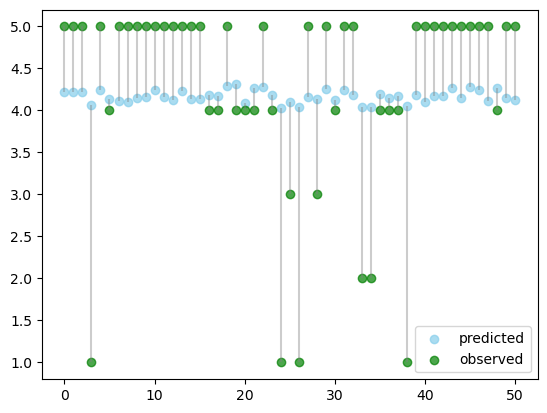

In [9]:
plt.vlines(x=range(0,len(predict_score)), ymin=predict_score, ymax = ori_score, color='grey', alpha=0.4)
plt.scatter(range(0, len(predict_score)), predict_score, color='skyblue', alpha=0.7, label='predicted')
plt.scatter(range(0, len(predict_score)), ori_score, color='green', alpha=0.7, label='observed')
plt.legend()

(array([ 733.,    0.,  465.,    0.,    0.,  674.,    0., 1131.,    0.,
        4997.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

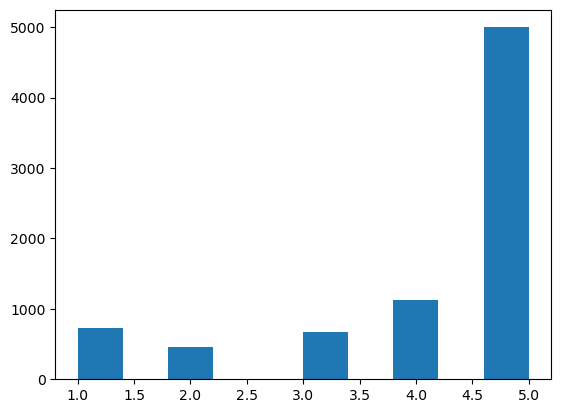

In [12]:
## histogram: training set scoring distribution
plt.hist(np.array(df_review.iloc[:,-4]))

__As shown above, the data is highly skewed (most people rated 5/5), which can lead to the training model less fit__

### Power analysis

Now that we know a training set with 8000 people can work well on predicting new scoring, the next question is, the __minimum size__ of training set that can make stable prediction.  
To address this question, we need to conduct a power analysis.  
The logic of it is creating a subset of 8000, and to see prediction performance of this subset. And for each subset, do iteration and get the average prediction performance.  
ps. I use Pearson r to represent performance in this case, since the feature-vector here is assumed to be normally distributed.
I also use euclidean distance as an alternative way to represent performance

In [ ]:
## in this case, size of training set would be 1-8000, set of test set would be 51
## create a dataframe to store prediction performance, which consists of pearson r(mean), r (sd), p value (mean), p (sd),  N
acc_predict_df = np.zeros((8000,5))
## create a dataframe to store the euclidean distance, which can also represent performance
eucl_predict_df = np.zeros((8000,2))
## loop
for i in range(3900,8000,100):
    #np.random.seed(3) ## set random seed for future replicate
    ## set number of iteration
    num_iteration = 20
    ## record the performance for each generation
    acc_predict_df_temp_r = np.zeros((1,num_iteration)) ## record r value
    acc_predict_df_temp_p = np.zeros((1,num_iteration)) ## record p value
    eucl_predict_df_temp = np.zeros((1,num_iteration)) ## record euclidean distance
    ## iteration
    for j in range(0,num_iteration):
        ## randomly select n reviews from the review dataframe
        review_rand_ls = np.random.choice(8000,i,replace=False)
        ## select the reviews that have been randomly generate
        df_train_temp = df_review.iloc[review_rand_ls,:]
        df_train_temp = df_train_temp.reset_index(drop=True) ## reset index
        df_train_embedding = model.encode(df_train_temp.iloc[:,-1]) ## create stored space
        ## make prediction for testing set
        ## calculate similarity code
        df_sim_code_temp = np.zeros((len(df_review_embedding_test_1),len(df_train_embedding)))
        df_sim_code_temp = pd.DataFrame(df_sim_code_temp)
        df_train_embedding = np.array(df_train_embedding)
        df_review_embedding_test_1 = np.array(df_review_embedding_test_1)
        for k in range(0,len(df_review_embedding_test_1)):
            for l in range(0,len(df_train_embedding)):
                df_sim_code_temp.iloc[k,l] = cosine_similarity([df_review_embedding_test_1[k],df_train_embedding[l]])[0,1] ## similarity between test data and train data
        ## create c score
        df_c_score_temp =  np.zeros((len(df_review_embedding_test_1),1))
        
        ## loop to write c score for each new stimuli
        for k in range(0,len(df_c_score_temp)):
            df_c_score_temp[k] = sum(abs(df_sim_code_temp.iloc[k,:]))
        ## calculate the predicted score
        predict_score_temp = np.zeros((len(df_review_embedding_test_1),1))
        ## loop to create dataframe for predicted score
        for k in range(0,len(predict_score_temp)):
            ## 1/c * sum(beta * sim code)
            predict_score_temp[k] = (1/df_c_score_temp[k]) * sum(df_train_temp.iloc[:,-4]*df_sim_code_temp.iloc[k,:]) ## df_train_temp[:,-4] is the score (pattern) in training set
        ## compared it with observed score
        acc_predict_df_temp_r[0,j] = pearsonr(ori_score, predict_score_temp[:,0])[0]
        acc_predict_df_temp_p[0,j] = pearsonr(ori_score, predict_score_temp[:,0])[1]
        eucl_predict_df_temp[0,j] = np.mean(abs(ori_score - predict_score_temp[:,0]))
    ## record r value (mean & sd) for each iteration
    acc_predict_df[i,0]= np.mean(acc_predict_df_temp_r)
    acc_predict_df[i,1]= np.std(acc_predict_df_temp_r)
    acc_predict_df[i,2]= np.mean(acc_predict_df_temp_p)
    acc_predict_df[i,3]= np.std(acc_predict_df_temp_p)
    acc_predict_df[i,4]= i
    eucl_predict_df[i,0] = np.mean(eucl_predict_df_temp)
    eucl_predict_df[i,1] = i
    print('training set finised:',i)

training set finised: 3900
training set finised: 4000
training set finised: 4100


#### Visualize power analylsis

In [4]:
## I ran the above code for several times and saved them into different files, so I need to input all the temp files 
acc_predict_df_1 = pd.read_csv('D:/Download/archive/acc_predict_df_new.csv', index_col=0)
acc_predict_df_2 = pd.read_csv('D:/Download/archive/acc_predict_df_new_230222.csv', index_col=0)
eucl_predict_df_1 = pd.read_csv('D:/Download/archive/eucl_predict_df_new.csv', index_col=0)
eucl_predict_df_2 = pd.read_csv('D:/Download/archive/eucl_predict_df_new_230222.csv', index_col=0)

## combine dataframe with rows
acc_predict_df_new = pd.concat([acc_predict_df_1, acc_predict_df_2])
eucl_predict_df_new = pd.concat([eucl_predict_df_1, eucl_predict_df_2])

In [1]:
## data cleaning
## after iteration, drop the rows with only zeros
acc_predict_df_new = acc_predict_df[~np.all(acc_predict_df == 0, axis=1)]
eucl_predict_df_new = eucl_predict_df[~np.all(eucl_predict_df == 0, axis=1)]

NameError: name 'acc_predict_df' is not defined

##### Correlation

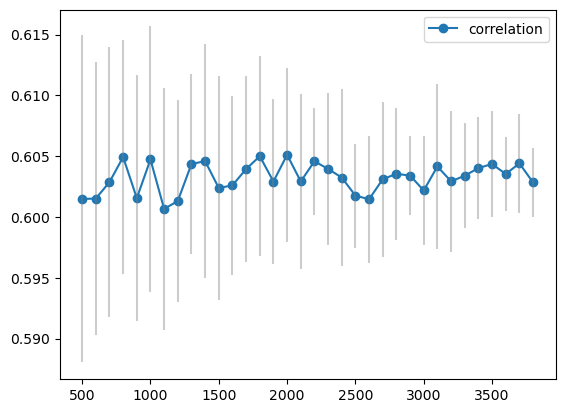

In [5]:
## Pearson r
acc_predict_df_new = pd.DataFrame(acc_predict_df_new)
plt.plot(acc_predict_df_new.iloc[:,-1], acc_predict_df_new.iloc[:,0], linestyle = '-', marker = 'o', label = 'correlation')
plt.vlines(x=acc_predict_df_new.iloc[:,-1], ymin=acc_predict_df_new.iloc[:,0] - acc_predict_df_new.iloc[:,1], 
           ymax = acc_predict_df_new.iloc[:,0] + acc_predict_df_new.iloc[:,1], color='grey', alpha=0.4)
plt.legend()

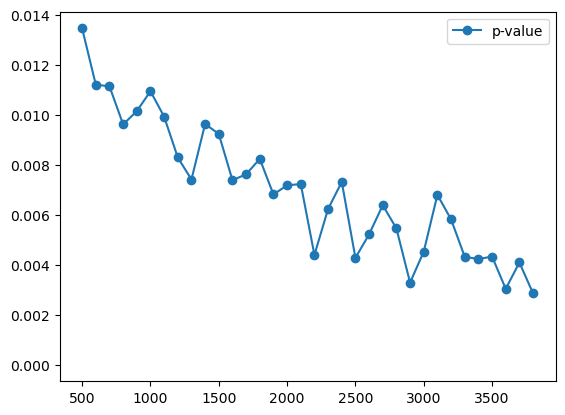

In [6]:
## p value
plt.plot(acc_predict_df_new.iloc[:,-1], acc_predict_df_new.iloc[:,1], linestyle = '-', marker = 'o', label = 'p-value')
plt.vlines(x=acc_predict_df_new.iloc[:,-1], ymin=acc_predict_df_new.iloc[:,2] - acc_predict_df_new.iloc[:,3], 
           ymax = acc_predict_df_new.iloc[:,2] + acc_predict_df_new.iloc[:,3], color='grey', alpha=0.4)
plt.legend()

##### Euclidean

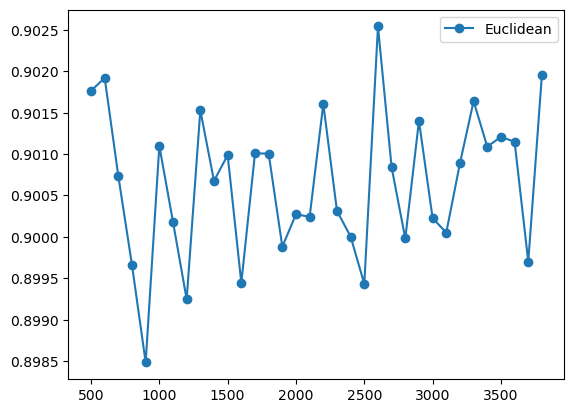

In [7]:
## euclidean distance
eucl_predict_df_new = pd.DataFrame(eucl_predict_df_new)
plt.plot(eucl_predict_df_new.iloc[:,-1], eucl_predict_df_new.iloc[:,0], linestyle = '-', marker = 'o', label = 'Euclidean')
plt.legend()

In [10]:
## temporaly save the dataframe
#acc_predict_df_new.to_csv('D:/Download/archive/acc_predict_df_new_230222.csv')
#eucl_predict_df_new.to_csv('D:/Download/archive/eucl_predict_df_new_230222.csv')


